In [1]:
import xgboost

import shap

In [2]:
# train XGBoost model
X, y = shap.datasets.adult(n_points=2000)
model = xgboost.XGBClassifier().fit(X, y)


# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
y_binary = [1 if income == True else 0 for income in y]
predict = model.predict(X)
Wrong_pred = []
for i in range(len(predict)):
    if predict[i] != y_binary[i]:
        Wrong_pred.append(i)
len(Wrong_pred)

74

(74, 12)


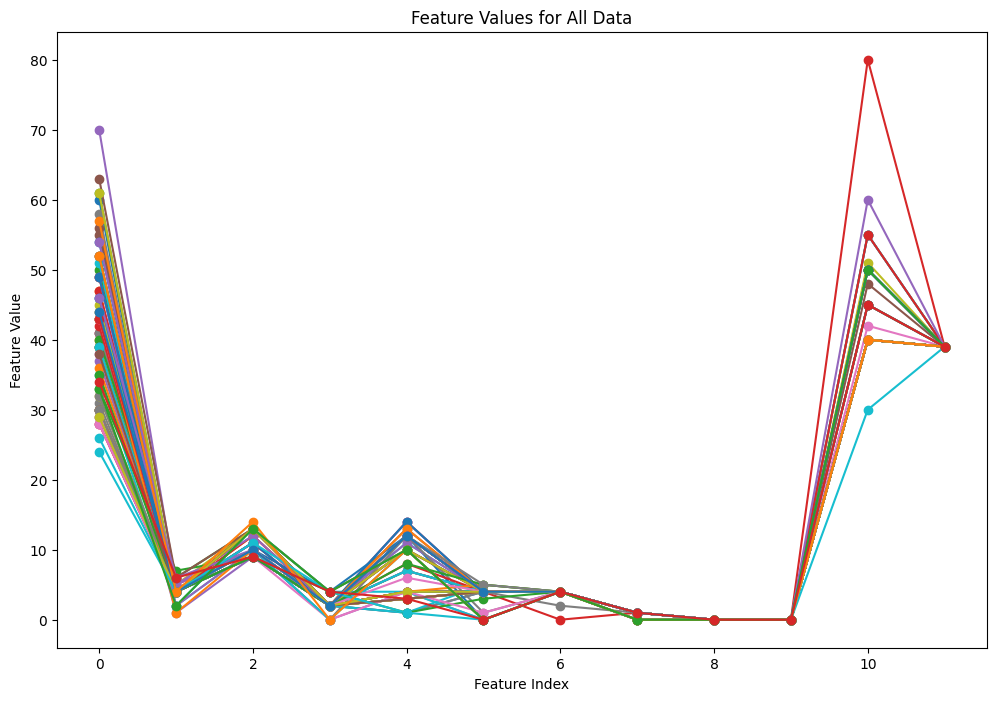

In [3]:
import matplotlib.pyplot as plt

# 获取所有数据
data = shap_values.data[Wrong_pred]
shap_values_all = shap_values.values[Wrong_pred]

print(data.shape)

# 获取数据的特征数量
num_features = data.shape[1]

# 设置图形大小
plt.figure(figsize=(12, 8))

# 遍历每个样本
for idx in range(len(data)):
    # 绘制每个样本的线图，横坐标是特征的索引，纵坐标是样本在该特征上的取值
    plt.plot(range(len(data[idx])), data[idx], '-o')

# 设置图形标题和坐标轴标签
plt.title('Feature Values for All Data')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')

# 显示图形
plt.show()


In [4]:
Wrong_pred

[26,
 54,
 80,
 109,
 154,
 166,
 191,
 234,
 254,
 275,
 320,
 332,
 379,
 461,
 472,
 478,
 486,
 575,
 619,
 641,
 676,
 688,
 740,
 760,
 769,
 791,
 838,
 854,
 891,
 900,
 928,
 946,
 949,
 970,
 1015,
 1060,
 1077,
 1078,
 1081,
 1104,
 1110,
 1143,
 1181,
 1184,
 1194,
 1241,
 1260,
 1262,
 1263,
 1285,
 1295,
 1308,
 1322,
 1416,
 1475,
 1482,
 1550,
 1580,
 1584,
 1621,
 1626,
 1654,
 1768,
 1775,
 1796,
 1821,
 1828,
 1832,
 1840,
 1855,
 1857,
 1898,
 1981,
 1985]

In [25]:
shap_values[54].data

array([49.,  4., 13.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.])

prediction:0,label:True


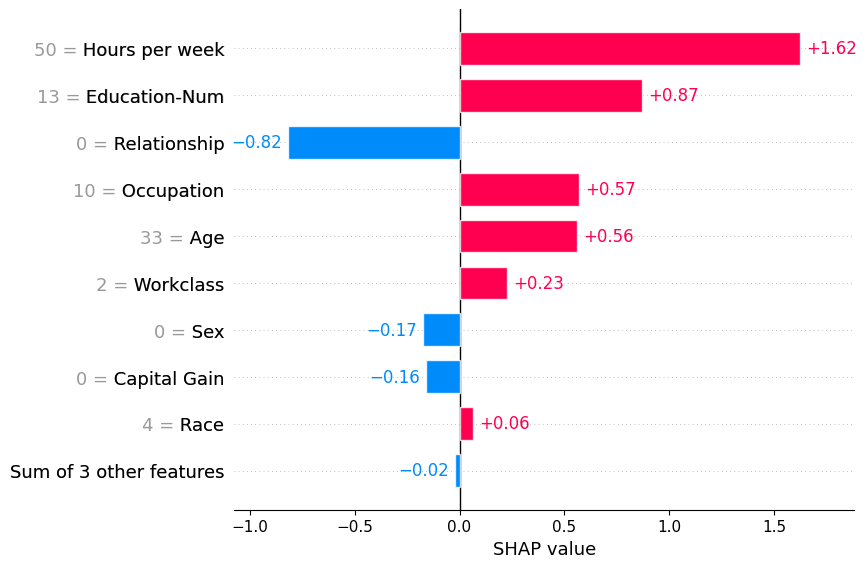

In [8]:
index = 1981
print("prediction:{},label:{}".format(predict[index], y[index]))
shap.plots.bar(shap_values[index])

current_shap_values = shap_values[index]


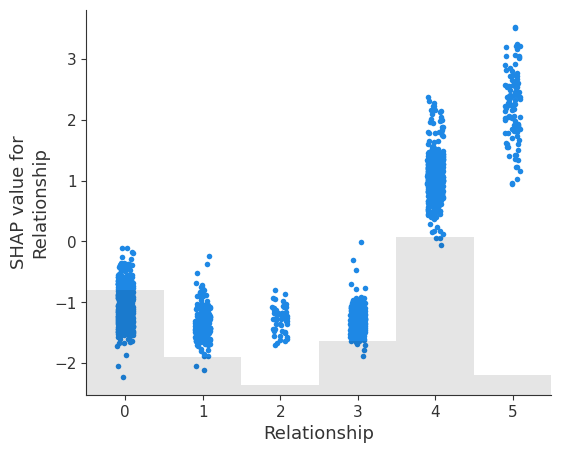

In [18]:
shap.plots.scatter(shap_values[:, "Relationship"])

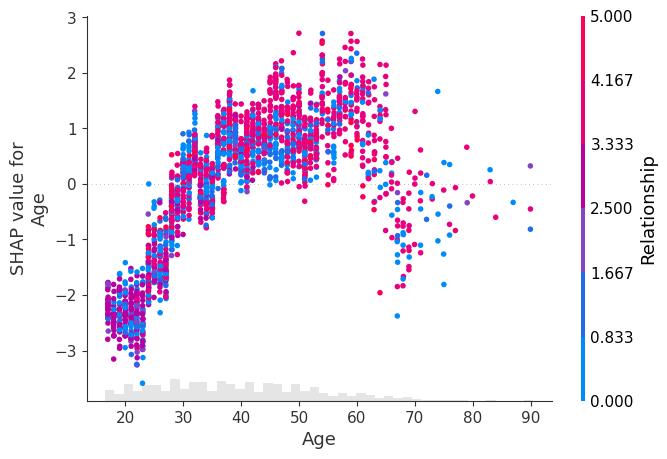

In [17]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values[:, "Relationship"])

In [9]:
current_shap_values

.values =
array([ 0.56053407,  0.22633029,  0.86989999, -0.05200639,  0.56909636,
       -0.81704802,  0.06273954, -0.17448481, -0.16029847, -0.00212513,
        1.62389867,  0.0321331 ])

.base_values =
-3.034144449280776

.data =
array([33.,  2., 13.,  4., 10.,  0.,  4.,  0.,  0.,  0., 50., 39.])

In [44]:
import pandas as pd
counterfactual_instance = [[49.,  4., 13.,  2.,  4.,  3.,  4.,  1.,  0.,  0., 40., 39.]]

counterfactual_instance_df = pd.DataFrame(counterfactual_instance, columns=X.columns)
# Predict the outcome for the counterfactual instance
counterfactual_prediction = model.predict(counterfactual_instance_df)[0]
counterfactual_probability = model.predict_proba(counterfactual_instance_df)[0, 1]
print(f"Counterfactual prediction: {counterfactual_prediction}, Counterfactual probability: {counterfactual_probability}")
initial_prediction = predict[index]
# Ensure the prediction is flipped
if counterfactual_prediction != initial_prediction:
    print("The prediction is successfully flipped.")
else:
    print("The prediction is not flipped. Adjust constraints or bounds and try again.")

# Compute SHAP values for the counterfactual instance
counterfactual_shap_values = explainer(counterfactual_instance_df)
counterfactual_shap_values = counterfactual_shap_values[0]



Counterfactual prediction: 0, Counterfactual probability: 0.20496925711631775
The prediction is successfully flipped.


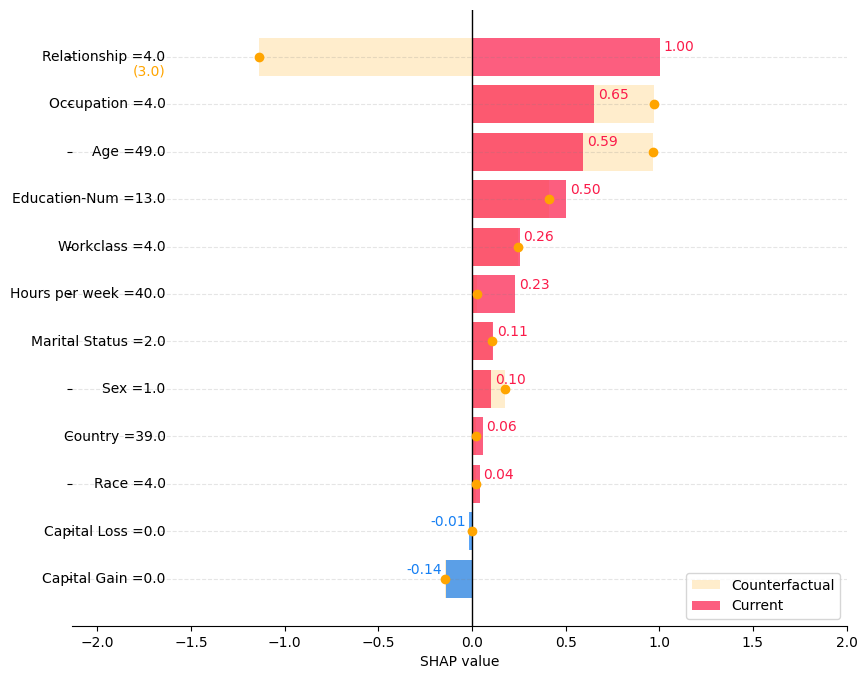

In [45]:
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np

# Assuming current_shap_values and general_case_shap_values are already defined
# And X is the dataset used for feature columns

# Convert SHAP values to a DataFrame for easier handling
shap_df = pd.DataFrame({
    'feature': X.columns,
    'current_value': current_shap_values.values,
    'current_feature_value': current_shap_values.data,
    'counterfactual_value': counterfactual_shap_values.values,
    'counterfactual_feature_value': counterfactual_shap_values.data,
})

# Sort by current SHAP values
shap_df = shap_df.sort_values(by='current_value', ascending=False).reset_index(drop=True)

# Define colors for positive and negative SHAP values
colors = ['#FB1A49' if val >= 0 else '#157FF3' for val in shap_df['current_value']]

# Plot SHAP values for the current instance
plt.figure(figsize=(10, 8))

# Plot general SHAP values as a background bar with lower opacity
plt.barh(shap_df['feature'], shap_df['counterfactual_value'], color='orange', alpha=0.2, label='Counterfactual')

# Plot current SHAP values
plt.barh(shap_df['feature'], shap_df['current_value'], color=colors, alpha=0.7, label='Current')

# Add a black vertical line at x=0
plt.axvline(x=0, color='black', linewidth=1)

# Add annotations comparing to the general case
for idx, row in shap_df.iterrows():
    plt.scatter([row['counterfactual_value']], [idx], color='orange', edgecolors='orange', zorder=5)
    # plt.text(row['general_value'], idx + 0.4, f"{row['general_value']:.2f}", color='orange')

# Add feature values next to the y-axis and on the bars
for idx, row in shap_df.iterrows():
    if row['current_value'] >= 0:
        plt.text(row['current_value'] + 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', color='#FB1A49')
    else:
        plt.text(row['current_value'] - 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', ha='right', color='#157FF3')

# plt.title('SHAP Values for Current Instance vs contercounterfactual example')
plt.xlabel('SHAP value')

# Create y-axis labels with feature names and corresponding feature values
ax = plt.gca()

# Set y-tick labels with custom formatting
min_value = min(shap_df['current_value'].min(), shap_df['counterfactual_value'].min())
max_value = max(shap_df['current_value'].max(), shap_df['counterfactual_value'].max())
# Set y-tick labels with custom formatting
for i, row in shap_df.iterrows():
    ax.text(min_value-0.5, i, f"{row['feature']} ={row['current_feature_value']:.1f}", va='center', ha='right', color='black', fontsize=10)
    if row['counterfactual_feature_value'] != row['current_feature_value']:
        ax.text(min_value -0.5, i + 0.3, f"({row['counterfactual_feature_value']:.1f})", va='center', ha='right', color='orange', fontsize=10)

# Remove the top, right, and left borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Invert y-axis to have the highest value on top
plt.gca().invert_yaxis()

# Add horizontal grid lines with dashed style
plt.gca().yaxis.grid(True, linestyle='--', which='both', color='gray', alpha=0.2)

# Hide the default y-tick labels
ax.set_yticklabels([])

# Adjust x-axis limits
plt.gca().set_xlim(left=min_value - 1,right=max_value+1)

# Show the legend
plt.legend()

plt.show()
